# Gaussian Process Regression on 2 dimensional data

This notebook fits a Gaussian Process model to a two dimensional training dataset.

In [1]:
from jax import config

# Double precision is highly recommended.
config.update("jax_enable_x64", True)

from jax import jit
from jax import lax
from jax import numpy as jnp
from jax import random
from jax import scipy
from jax import value_and_grad
from jax import vmap

import matplotlib.pyplot as plt
import optax

from bojax.prediction import bijectors, kernels, means
from bojax.prediction.processes import gaussian

In [2]:
SEED = 0
LOWER_BOUND = 0
UPPER_BOUND = 2
NUM_DATA_POINTS = 100
NOISE = 1e-4
LEARNING_RATE = 0.01

## Dataset

For our synthetic training dataset we first draw random samples from a uniform distribution and then generate observations by applying the two dimensional objective function.

In [3]:
data_key = random.key(SEED)

In [4]:
def objective(x):
    return (
        jnp.sin(5 * x[..., 0] / 2 - 2.5) * jnp.cos(2.5 - 5 * x[..., 1])
        + (5 * x[..., 1] / 2 + 0.5) ** 2 / 10
    ) / 5 + 0.2

In [5]:
x_train = random.uniform(data_key, (NUM_DATA_POINTS, 2), minval=LOWER_BOUND, maxval=UPPER_BOUND)
y_train = objective(x_train)

Next we plot the observations on top of latent objective function.

In [6]:
grid = jnp.linspace(LOWER_BOUND, UPPER_BOUND, 101)
x1, x2 = jnp.meshgrid(grid, grid, indexing="ij")
x_test = jnp.vstack([x1.flatten(), x2.flatten()]).transpose(-1, -2)
y_test = objective(x_test)

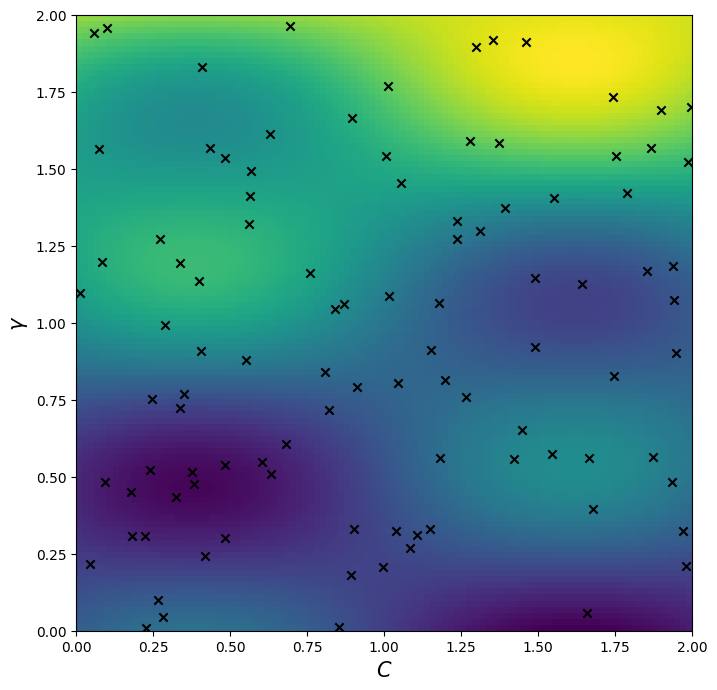

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(x_train[..., 0], x_train[..., 1], color='black', marker='x', label='observations')
ax.imshow(y_test.reshape(101, 101).T, origin="lower", extent=[LOWER_BOUND, UPPER_BOUND, LOWER_BOUND, UPPER_BOUND])
ax.set_xlabel("$C$", fontsize=15)
ax.set_ylabel("$\gamma$", fontsize=15)

plt.show()

## Fitting the gaussian process model

With the sythentic training dataset in place, we can move on to fitting a gaussian process model to the data. For that, we define a broad prior over all candidate latent functions consisting of a zero-mean gaussian process with a scaled Matern 2.5 kernel. Note, we constrain the prior hyperparameters `constant`, `amplitude`, and `length_scale` by the `softplus` bijector. This is crucial during training, as they are required to be positive.

In [8]:
bijector = bijectors.softplus()

In [9]:
def prior(params):
    return gaussian.prior(
        vmap(means.constant(params['constant'])),
        vmap(vmap(kernels.scale(bijector.forward(params['amplitude']), kernels.matern_five_halves(bijector.forward(params['length_scale']))), in_axes=(None, 0)), in_axes=(0, None)),
        NOISE,
    )

Next we initialise the parameters and plot the mean and starndard deviation of our prior destribution.

In [10]:
params = {
    'constant': jnp.zeros(()),
    'amplitude': jnp.zeros(()),
    'length_scale': jnp.zeros((2,)),
}

In [11]:
prior_mean, prior_cov = prior(params)(x_test)
prior_scale = jnp.sqrt(jnp.diag(prior_cov))

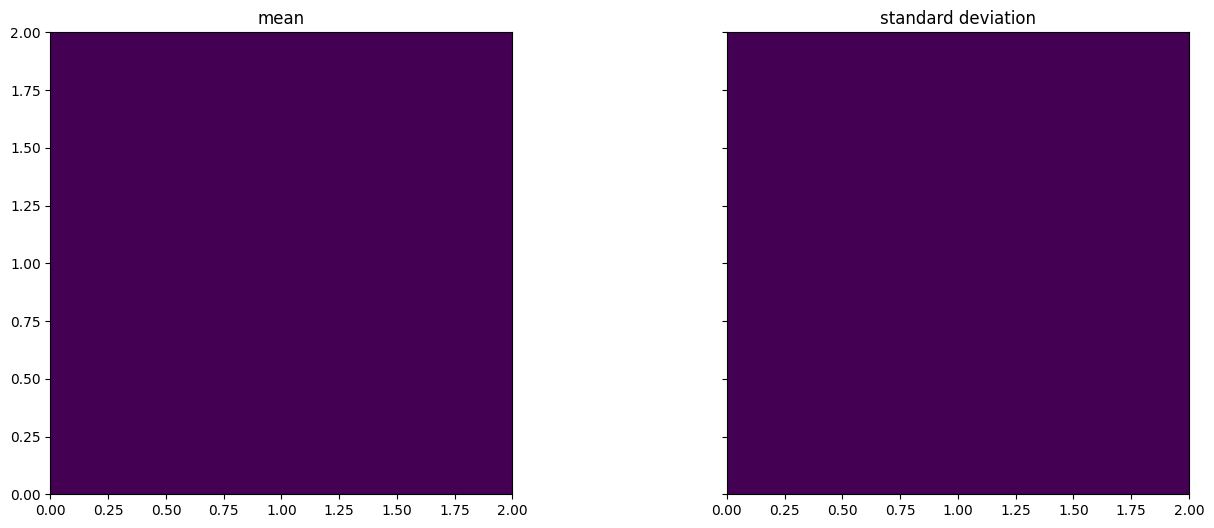

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

axs[0].set_title('mean')
axs[0].imshow(
    prior_mean.reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=[LOWER_BOUND, UPPER_BOUND, LOWER_BOUND, UPPER_BOUND]
)

axs[1].set_title('standard deviation')
axs[1].imshow(
    prior_scale.reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=[LOWER_BOUND, UPPER_BOUND, LOWER_BOUND, UPPER_BOUND]
)

plt.show()

To fit the parameters we use the Adam optimizer by minimizing the negative log likelihood on the training dataset.

In [13]:
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(params)

In [14]:
def train_step(state, iteration):
    def loss_fn(params):            
        loc, scale = prior(params)(x_train)
        return -scipy.stats.multivariate_normal.logpdf(y_train, loc, scale)

    loss, grads = value_and_grad(loss_fn)(state[0])
    updates, opt_state = optimizer.update(grads, state[1])
    params = optax.apply_updates(state[0], updates)
    
    return (params, opt_state), loss

In [15]:
(next_params, next_opt_state), history = lax.scan(jit(train_step), (params, opt_state), jnp.arange(500))

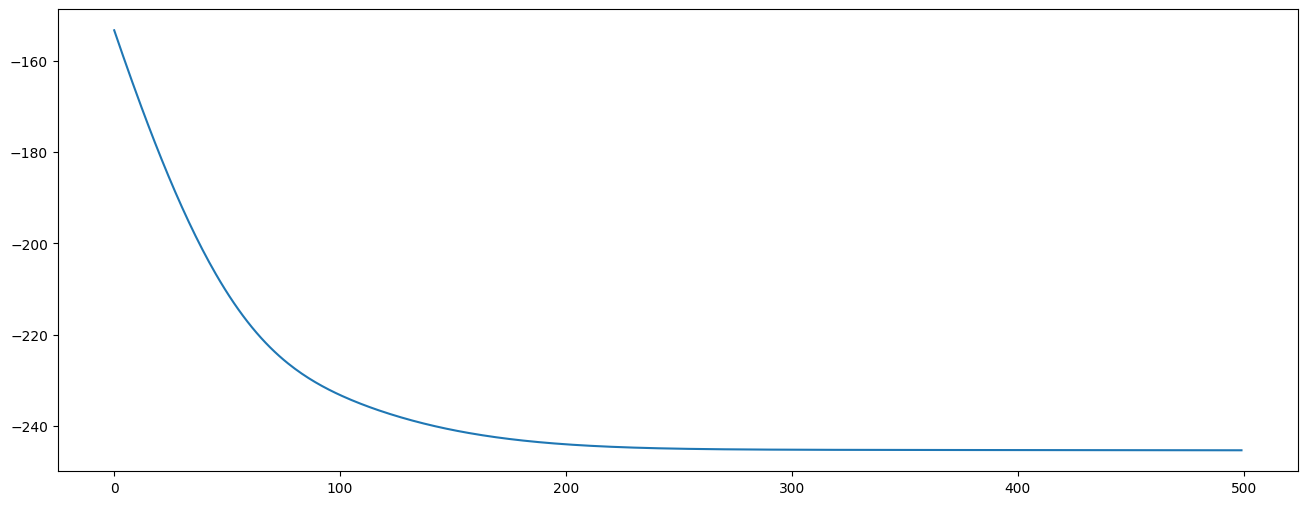

In [16]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(history, label='Negative Log Likelihood')

plt.show()

## Prediction

As the final step construct the posterior distribution by conditioning the prior on the training data and plot its mean and standard deviation.

In [17]:
posterior_mean, posterior_cov = gaussian.posterior(
    x_train,
    y_train,
    vmap(means.constant(params['constant'])),
    vmap(vmap(kernels.scale(bijector.forward(params['amplitude']), kernels.matern_five_halves(bijector.forward(params['length_scale']))), in_axes=(None, 0)), in_axes=(0, None)),
    NOISE,
)(x_test)

In [18]:
posterior_scale = jnp.sqrt(jnp.diag(posterior_cov))

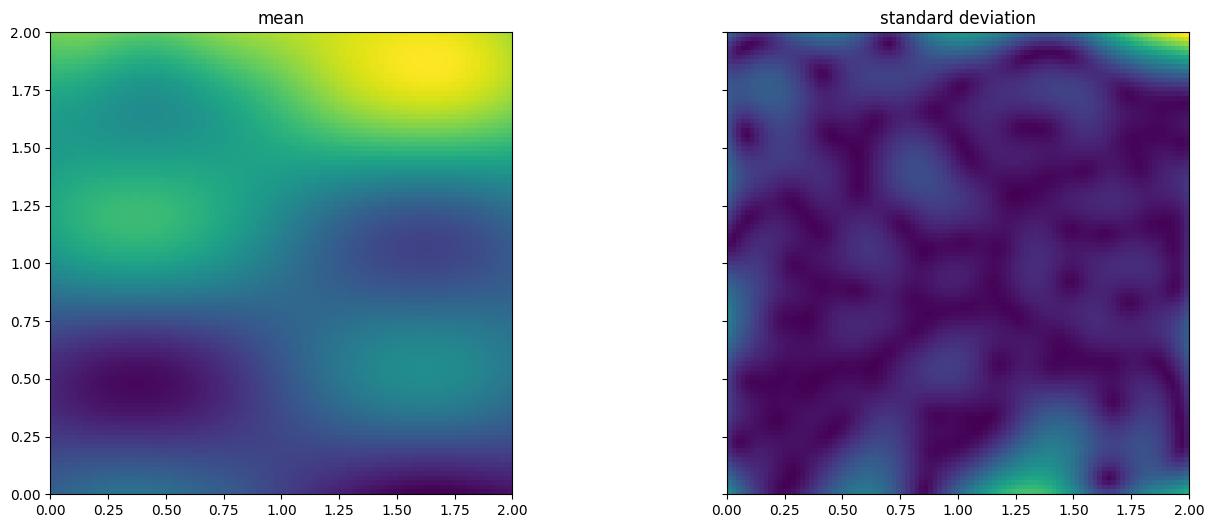

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

axs[0].set_title('mean')
axs[0].imshow(
    posterior_mean.reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=[LOWER_BOUND, UPPER_BOUND, LOWER_BOUND, UPPER_BOUND]
)

axs[1].set_title('standard deviation')
axs[1].imshow(
    posterior_scale.reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=[LOWER_BOUND, UPPER_BOUND, LOWER_BOUND, UPPER_BOUND]
)

plt.show()